In [17]:
import numpy as np
import scanpy as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os

from ete3 import Tree

import pickle as pic

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm_notebook, tqdm


from utilities import de_utils

import gseapy
import statsmodels.api as sm
from patsy import dmatrices
import colorcet as cc

import matplotlib



## Read in 10X data matrix & pre-process data

In [18]:
path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/"
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

adata.var_names = [x.upper() for x in adata.var_names]

all_genes = adata.var_names

meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col=0)
latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0)
latent.index = adata.obs_names

gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values
adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


((43423, 33694), (43423, 10), (40969, 9))

In [19]:
ts_rna_overlap = np.intersect1d(adata.obs_names, meta.index)
len(ts_rna_overlap), len(adata.obs_names), len(meta.index)

(37814, 43423, 40969)

In [20]:
meta_filter = np.logical_not(meta["TreeMetRate"].isna())
meta = meta.loc[meta_filter]

ts_rna_overlap = np.intersect1d(adata.obs_names, meta.index)
meta = meta.loc[ts_rna_overlap]
adata = adata[ts_rna_overlap,:]

adata.shape

(35007, 33694)

In [21]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
print(len(mito_genes))
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['nUMI'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1

adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")


13


Trying to set attribute `.obs` of view, making a copy.


In [22]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))
sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

In [23]:
adata = adata[adata.obs.percent_mito <= 0.20, :]

In [24]:
scale_factor

6362.0

In [25]:
adata.shape

(35006, 33694)

In [26]:
# filter out genes not expressed in at least 1% of cells
thresh = 0.01*adata.shape[0]

sc.pp.filter_genes(adata, min_cells=thresh)

Trying to set attribute `.var` of view, making a copy.


In [27]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [28]:
filter_result = list(map(lambda x: x in gene_list, adata.var_names))
# sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result]

In [29]:
sc.pp.log1p(adata)

/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Perform dimensionality reduction & visualization

In [30]:
latent = latent.loc[adata.obs_names].values

In [31]:
adata.obsm["X_pca"] = latent

In [32]:
sc.tl.tsne(adata, random_state=2, n_pcs=10, n_jobs = 10)

In [33]:
sc.pp.neighbors(adata, n_neighbors = int(np.sqrt(adata.X.shape[0])))
sc.tl.umap(adata)

/home/eecs/mattjones/.local/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../home/eecs/mattjones/.local/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/eecs/mattjones/.local/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../home/ee

In [34]:
sc.tl.louvain(adata)

In [35]:
adata.obs['scTreeMetRate'].max(), adata.obs['scTreeMetRate'].min()

(0.4431990380509019, 0.0)

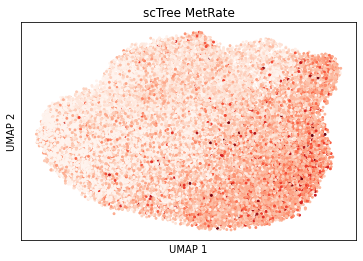

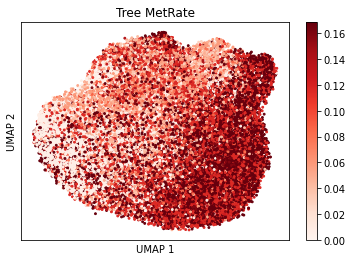

Text(0, 0.5, 'UMAP 2')

<Figure size 504x504 with 0 Axes>

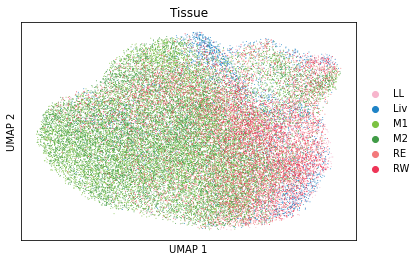

<Figure size 504x504 with 0 Axes>

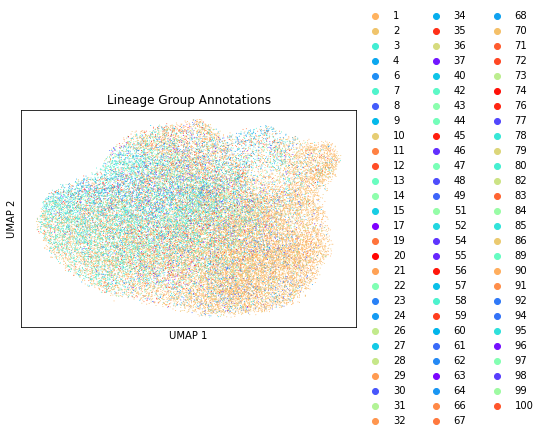

In [38]:
# h = plt.figure(figsize = (7,7))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], cmap = 'Reds', s = 120000 / adata.shape[0],
                            c = adata.obs['scTreeMetRate'])
plt.title("scTree MetRate")
plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
ax.set_yticks([])
ax.set_xticks([])
# plt.savefig('figs/5k/umap_sctreemetrate.5k.eps')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], cmap = 'Reds', s = 120000 / adata.shape[0],
                            c = adata.obs['TreeMetRate'])
plt.title("Tree MetRate")
plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
ax.set_yticks([])
ax.set_xticks([])
plt.colorbar()
plt.savefig('figs/5k/umap_treemetrate.5k.colorbar.eps')
plt.show()


h = plt.figure(figsize = (7,7))
color_to_samp = {"LL": "#f7b5cc", "Liv": "#1f83c6", "M1": "#7cc242",  "M2": "#409b46", "RE": "#f3797b", "RW": "#ee3557"}
colors = adata.obs.apply(lambda x: color_to_samp[x.sampleID], axis=1)
ax = sc.pl.umap(adata, color = 'sampleID', palette = list(color_to_samp.values()), show=False)
plt.title("Tissue")
plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
# plt.savefig('figs/5k/umap_tissue.5k.eps', bbox_inches='tight')


norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
color_vec = list(map(lambda x: matplotlib.colors.rgb2hex(matplotlib.cm.rainbow(norm(x))), range(100)))
np.random.shuffle(color_vec)
adata.obs['LineageGroup'] = adata.obs['LineageGroup'].astype('category')
h = plt.figure(figsize = (7,7))
ax = sc.pl.umap(adata, color = "LineageGroup", show = False, palette = color_vec)
plt.title("Lineage Group Annotations")
plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
# plt.savefig("figs/5k/umap_lg.5k.eps", bbox_inches='tight')

# Find correlates of metastatic ability

In [404]:
met_scores = pd.read_csv("data/lg_metastatic_scoresAllele.5k.txt", sep='\t', index_col = 0)
sig_scores = pd.read_csv("../JQ19/5k/RNA/JQ19.sigscores.txt", sep='\t', index_col = 0)

In [405]:
keep_cells = np.intersect1d(sig_scores.index, adata.obs_names)
keep_cells = np.intersect1d(keep_cells, adata.obs.index)

meta_filter = list(map(lambda x: x in keep_cells, adata.obs.index.values))
adata = adata[meta_filter, :]

sig_scores_subset = sig_scores.loc[keep_cells]

In [406]:
sig_scores_subset.shape

(35005, 3685)

### Evaluate correlation between proliferative signatures and single-cell TreeMetRate

In [407]:
adata.obs.shape

(35005, 14)

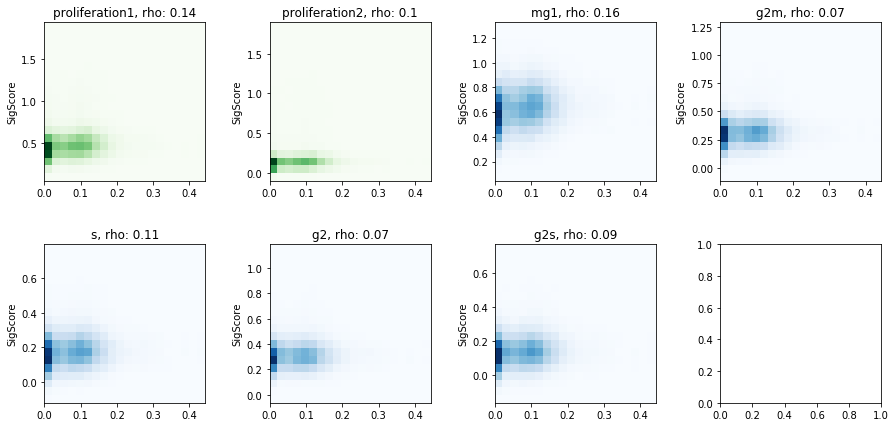

In [410]:
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
colors = ['Greens', 'Greens', 'Blues', 'Blues', 'Blues', 'Blues', 'Blues']
names = ['proliferation1', 'proliferation2', 'mg1', 'g2m', 's', 'g2', 'g2s']
for j, sig in zip(range(7), ['BENPORATH_PROLIFERATION', 'ROSTY_CERVICAL_CANCER_PROLIFERATION_CLUSTER', 'WHITFIELD_CELL_CYCLE_M_G1', 'WHITFIELD_CELL_CYCLE_G2_M', 
            'WHITFIELD_CELL_CYCLE_S', 'WHITFIELD_CELL_CYCLE_G2', 'WHITFIELD_CELL_CYCLE_G1_S']):
    
    n = names[j]
    _color = colors[j]
    x = int((j)/4)
    y = int((j)%4)
    
    axarr[x,y].hist2d(adata.obs['scTreeMetRate'], sig_scores_subset[sig], bins=[20, 20], cmap=_color)
    # sns.scatterplot(adata.obs['DynamicMetScore'], sig_scores_subset[sig], ax = axarr[x,y], alpha=0.05, color='black')
    
    axarr[x,y].set_title(n + ', rho: ' + str(round(scs.pearsonr(adata.obs['scTreeMetRate'], sig_scores_subset[sig])[0], 2)))
    axarr[x, y].set_ylabel('SigScore')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('cellcyclesig_vs_treemetrate.eps')
plt.show()

# Look at single-cell correlates

In [166]:
corrs = {}
signif_sigs = {}

for sig in tqdm(sig_scores_subset.columns):
    
    pcorr = scs.pearsonr(sig_scores_subset.loc[adata.obs.index, sig], adata.obs['DynamicMetScore'])[0]
    scorr = scs.spearmanr(sig_scores_subset[sig], adata.obs['DynamicMetScore'])[0]
    if abs(pcorr) > 0.2:
        print(sig, pcorr, scorr)
        signif_sigs[sig] = (pcorr, scorr)
    corrs[sig] = (pcorr, scorr)
        

  0%|          | 12/3752 [00:00<01:08, 54.87it/s]

HALLMARK_PROTEIN_SECRETION 0.20103048420444253 0.020870447682749645
HALLMARK_INTERFERON_ALPHA_RESPONSE 0.22779000631893656 0.024516650039015802


  5%|▍         | 186/3752 [00:03<01:04, 55.21it/s]

KEGG_OLFACTORY_TRANSDUCTION -0.20354994003463742 -0.03192632064098486


  7%|▋         | 270/3752 [00:04<01:03, 54.98it/s]

BIOCARTA_COMP_PATHWAY -0.23481132723440182 -0.02133580583129375


  7%|▋         | 276/3752 [00:05<01:03, 54.42it/s]

BIOCARTA_CTL_PATHWAY 0.20454863303524695 0.033660795939938544


 18%|█▊        | 674/3752 [00:12<00:54, 56.78it/s]

PID_RAS_PATHWAY 0.22407075658979775 0.015173071500973197


 19%|█▉        | 720/3752 [00:13<00:51, 59.02it/s]

REACTOME_NEF_MEDIATED_DOWNREGULATION_OF_MHC_CLASS_I_COMPLEX_CELL_SURFACE_EXPRESSION 0.20551973626127637 0.033000498228959646


 20%|█▉        | 732/3752 [00:13<00:51, 58.97it/s]

REACTOME_ENDOSOMAL_VACUOLAR_PATHWAY 0.2247043592730459 0.024812403268966103


 20%|█▉        | 744/3752 [00:13<00:55, 54.45it/s]

REACTOME_NEF_MEDIATES_DOWN_MODULATION_OF_CELL_SURFACE_RECEPTORS_BY_RECRUITING_THEM_TO_CLATHRIN_ADAPTERS 0.20017773393190444 0.03606672504577903


 20%|██        | 762/3752 [00:14<00:53, 55.97it/s]

REACTOME_DEFENSINS -0.22799529623784817 -0.0293965722483627


 20%|██        | 768/3752 [00:14<00:53, 56.07it/s]

REACTOME_BETA_DEFENSINS -0.22623416559185508 -0.029205895663424672


 26%|██▌       | 966/3752 [00:17<00:50, 55.64it/s]

REACTOME_OLFACTORY_SIGNALING_PATHWAY -0.22575854273982995 -0.030986198076598075


 33%|███▎      | 1224/3752 [00:22<00:45, 55.88it/s]

REACTOME_INTERFERON_SIGNALING 0.20397512628004175 0.02731396838064443


 35%|███▌      | 1320/3752 [00:24<00:46, 52.68it/s]

REACTOME_ANTIGEN_PRESENTATION_FOLDING_ASSEMBLY_AND_PEPTIDE_LOADING_OF_CLASS_I_MHC 0.23452831664094095 0.02330538857418778
REACTOME_CLASS_I_MHC_MEDIATED_ANTIGEN_PROCESSING_PRESENTATION 0.20544057121244524 0.02903151556655193


 36%|███▌      | 1336/3752 [00:24<00:49, 48.99it/s]

REACTOME_INITIAL_TRIGGERING_OF_COMPLEMENT -0.23894336064538182 -0.021634287127567597


 37%|███▋      | 1383/3752 [00:25<01:00, 39.08it/s]

ONKEN_UVEAL_MELANOMA 0.23141629650292245 0.02692613322024839
SCHUETZ_BREAST_CANCER_DUCTAL_INVASIVE 0.20224583366917834 0.01982110635478287


 37%|███▋      | 1388/3752 [00:25<00:58, 40.71it/s]

WATANABE_COLON_CANCER_MSI_VS_MSS 0.22977549839740358 0.006975088347558383


 37%|███▋      | 1406/3752 [00:25<00:45, 51.40it/s]

TURASHVILI_BREAST_DUCTAL_CARCINOMA_VS_DUCTAL_NORMAL 0.21630668707148834 -0.006023008022665283
TURASHVILI_BREAST_DUCTAL_CARCINOMA_VS_LOBULAR_NORMAL 0.26234818402946286 0.02303536565364572


 38%|███▊      | 1412/3752 [00:26<00:44, 52.72it/s]

FULCHER_INFLAMMATORY_RESPONSE_LECTIN_VS_LPS 0.2062080662744784 0.025869288622284378


 38%|███▊      | 1425/3752 [00:26<00:41, 56.02it/s]

DIAZ_CHRONIC_MEYLOGENOUS_LEUKEMIA 0.2073865505858337 0.026428131884856328


 38%|███▊      | 1438/3752 [00:26<00:40, 57.51it/s]

DOANE_BREAST_CANCER_ESR1 0.2011206979076797 0.006088359480625817
LAIHO_COLORECTAL_CANCER_SERRATED 0.2940882081378837 0.03464553886193396


 38%|███▊      | 1444/3752 [00:26<00:40, 57.10it/s]

GRABARCZYK_BCL11B_TARGETS 0.20606260634420606 0.022994000844474036


 39%|███▉      | 1471/3752 [00:27<00:38, 59.30it/s]

RUNNE_GENDER_EFFECT -0.34309168209544477 -0.06297404613392982


 40%|███▉      | 1491/3752 [00:27<00:37, 59.93it/s]

MULLIGHAN_MLL_SIGNATURE_1 0.21467410279680696 0.02122257963574


 41%|████      | 1521/3752 [00:27<00:40, 55.22it/s]

KIM_WT1_TARGETS -0.20632668585316902 -0.008220165878947144


 41%|████      | 1539/3752 [00:28<00:40, 54.27it/s]

WAMUNYOKOLI_OVARIAN_CANCER_GRADES_1_2 0.23348675559124152 0.022672760152820038


 41%|████      | 1545/3752 [00:28<00:40, 54.35it/s]

GOZGIT_ESR1_TARGETS -0.20291045506961355 -0.010305639057595217


 42%|████▏     | 1563/3752 [00:28<00:41, 52.72it/s]

DELYS_THYROID_CANCER 0.21018013374204714 0.03028528105342332


 43%|████▎     | 1617/3752 [00:29<00:40, 52.37it/s]

JOHANSSON_GLIOMAGENESIS_BY_PDGFB 0.2553907706639316 0.029760460268485653


 44%|████▍     | 1647/3752 [00:30<00:38, 54.66it/s]

HWANG_PROSTATE_CANCER_MARKERS 0.21554285752336144 0.03316918763958426


 45%|████▍     | 1677/3752 [00:30<00:36, 56.15it/s]

CHASSOT_SKIN_WOUND -0.20198504768138786 -0.0018096319364922827


 46%|████▋     | 1743/3752 [00:32<00:37, 53.17it/s]

NAKAMURA_ALVEOLAR_EPITHELIUM -0.23324597284564957 -0.02470805699666426


 48%|████▊     | 1785/3752 [00:32<00:35, 55.42it/s]

SCHLOSSER_MYC_AND_SERUM_RESPONSE_SYNERGY 0.20508562478339887 0.018064214835348886


 48%|████▊     | 1809/3752 [00:33<00:35, 54.29it/s]

BOWIE_RESPONSE_TO_TAMOXIFEN 0.22805852126163922 0.010837011597585714


 48%|████▊     | 1815/3752 [00:33<00:36, 53.18it/s]

HERNANDEZ_MITOTIC_ARREST_BY_DOCETAXEL_2 0.21586456997849252 0.03334974473169853


 49%|████▊     | 1827/3752 [00:33<00:36, 52.37it/s]

EINAV_INTERFERON_SIGNATURE_IN_CANCER 0.21457021569786952 0.0037153016037546347


 49%|████▉     | 1845/3752 [00:34<00:35, 53.05it/s]

SEITZ_NEOPLASTIC_TRANSFORMATION_BY_8P_DELETION 0.23567175004766436 0.01458493958625432


 51%|█████     | 1905/3752 [00:35<00:33, 54.70it/s]

YANG_BREAST_CANCER_ESR1_BULK 0.20558490880659083 0.009158943579910272


 53%|█████▎    | 1989/3752 [00:36<00:32, 54.41it/s]

LOCKWOOD_AMPLIFIED_IN_LUNG_CANCER 0.20285183361802134 0.033187435725082925
WEI_MYCN_TARGETS_WITH_E_BOX 0.21297060631859208 0.024960699789390434


 54%|█████▍    | 2031/3752 [00:37<00:31, 54.28it/s]

RICKMAN_HEAD_AND_NECK_CANCER_B -0.20543794992190995 -0.03747400555274972


 58%|█████▊    | 2175/3752 [00:40<00:29, 52.94it/s]

TARTE_PLASMA_CELL_VS_B_LYMPHOCYTE 0.21333842200153902 0.019760951493593516
SWEET_KRAS_TARGETS -0.2104480347914442 -0.008818722885223982


 58%|█████▊    | 2193/3752 [00:40<00:29, 52.99it/s]

BASSO_B_LYMPHOCYTE_NETWORK 0.22599420127043982 0.028835706587336814


 59%|█████▉    | 2205/3752 [00:40<00:29, 53.32it/s]

GNATENKO_PLATELET_SIGNATURE 0.20476798606912106 0.016794525861820155


 59%|█████▉    | 2217/3752 [00:40<00:31, 49.31it/s]

DER_IFN_ALPHA_RESPONSE 0.22121496148499697 0.029153302702412558


 59%|█████▉    | 2227/3752 [00:41<00:32, 47.26it/s]

DER_IFN_BETA_RESPONSE 0.22208305856825983 0.02953872674740921


 60%|█████▉    | 2237/3752 [00:41<00:33, 44.97it/s]

RADAEVA_RESPONSE_TO_IFNA1 0.23344691057519795 0.020354828866645854


 60%|█████▉    | 2247/3752 [00:41<00:37, 39.72it/s]

WIELAND_UP_BY_HBV_INFECTION 0.20965752845587485 0.02413701716599631


 61%|██████    | 2287/3752 [00:42<00:29, 49.20it/s]

FLECHNER_BIOPSY_KIDNEY_TRANSPLANT_OK_VS_DONOR 0.211427341118294 0.025629885124984708


 64%|██████▍   | 2405/3752 [00:44<00:23, 56.29it/s]

REN_ALVEOLAR_RHABDOMYOSARCOMA -0.2560684795727091 -0.03660725188571026


 65%|██████▍   | 2435/3752 [00:45<00:22, 57.38it/s]

IVANOVA_HEMATOPOIESIS_LATE_PROGENITOR 0.2063493349375164 0.02901545445983931


 70%|███████   | 2639/3752 [00:49<00:21, 50.86it/s]

JIANG_HYPOXIA_CANCER 0.21204643059609038 0.0183086805265718


 72%|███████▏  | 2699/3752 [00:50<00:20, 51.47it/s]

CREIGHTON_ENDOCRINE_THERAPY_RESISTANCE_3 0.2301776790316866 0.015744947026827518


 73%|███████▎  | 2747/3752 [00:51<00:19, 50.95it/s]

WANG_LSD1_TARGETS 0.20948402468746422 0.019436890266262837


 74%|███████▍  | 2771/3752 [00:51<00:19, 51.36it/s]

KONDO_PROSTATE_CANCER_WITH_H3K27ME3 -0.20826948793969424 -0.022941979492413736


 76%|███████▌  | 2837/3752 [00:52<00:17, 51.43it/s]

MASRI_RESISTANCE_TO_TAMOXIFEN_AND_AROMATASE_INHIBITORS 0.22901334580199728 0.021467446372255138


 76%|███████▌  | 2843/3752 [00:53<00:17, 50.96it/s]

ACEVEDO_LIVER_CANCER 0.2536415813960168 0.02660737406453337


 76%|███████▌  | 2849/3752 [00:53<00:17, 50.89it/s]

ACEVEDO_LIVER_TUMOR_VS_NORMAL_ADJACENT_TISSUE 0.2039406370053188 0.026641697135052295


 76%|███████▌  | 2855/3752 [00:53<00:17, 50.71it/s]

SMID_BREAST_CANCER_RELAPSE_IN_LUNG -0.21784288958136996 -0.01553016817547312


 76%|███████▋  | 2867/3752 [00:53<00:17, 50.79it/s]

LE_SKI_TARGETS 0.23704058433331215 0.029545021444996905
BONOME_OVARIAN_CANCER_SURVIVAL_OPTIMAL_DEBULKING 0.2018134336530393 0.025540329553984067


 78%|███████▊  | 2945/3752 [00:55<00:16, 50.41it/s]

CADWELL_ATG16L1_TARGETS -0.20947439233318313 -0.00790726238027508


 81%|████████▏ | 3050/3752 [00:57<00:13, 51.17it/s]

ROSS_LEUKEMIA_WITH_MLL_FUSIONS 0.20950584250142676 0.02785086485317084


 82%|████████▏ | 3067/3752 [00:57<00:14, 48.74it/s]

LEE_NAIVE_T_LYMPHOCYTE -0.26496906508991425 -0.03357317368141289


 85%|████████▍ | 3182/3752 [00:59<00:10, 52.04it/s]

YAGI_AML_WITH_11Q23_REARRANGED 0.23461913162222822 0.026714251487375374


 86%|████████▌ | 3224/3752 [01:00<00:09, 54.12it/s]

KUROZUMI_RESPONSE_TO_ONCOCYTIC_VIRUS_AND_CYCLIC_RGD -0.20833902096058796 -0.026071663417173763


 88%|████████▊ | 3290/3752 [01:01<00:08, 53.10it/s]

MIKKELSEN_ES_HCP_WITH_H3_UNMETHYLATED -0.2346316108938108 -0.04483230089809988


 88%|████████▊ | 3302/3752 [01:02<00:08, 52.28it/s]

MIKKELSEN_MEF_HCP_WITH_H3K27ME3 -0.20837324450423073 -0.029337723475740148
MIKKELSEN_MEF_HCP_WITH_H3_UNMETHYLATED -0.24418188951077688 -0.0337669863851579


 88%|████████▊ | 3314/3752 [01:02<00:09, 48.55it/s]

YAO_TEMPORAL_RESPONSE_TO_PROGESTERONE_CLUSTER_13 0.20119612789763938 0.03659983921231299


 88%|████████▊ | 3320/3752 [01:02<00:08, 49.05it/s]

YAO_TEMPORAL_RESPONSE_TO_PROGESTERONE_CLUSTER_16 0.20843899855637568 0.030568798682069496


 89%|████████▉ | 3341/3752 [01:02<00:09, 45.49it/s]

ZEMBUTSU_SENSITIVITY_TO_CYCLOPHOSPHAMIDE 0.24502728956741243 0.014373842584815024


 90%|████████▉ | 3366/3752 [01:03<00:07, 48.46it/s]

BROWNE_HCMV_INFECTION_2HR -0.22794751803424892 -0.013852621638528354


 91%|█████████ | 3396/3752 [01:04<00:07, 48.30it/s]

CHICAS_RB1_TARGETS_CONFLUENT 0.22489046774343582 0.024280092764702447


 92%|█████████▏| 3436/3752 [01:04<00:06, 49.16it/s]

PILON_KLF1_TARGETS -0.21423763191759468 -0.028715651623684044


 92%|█████████▏| 3446/3752 [01:05<00:06, 48.32it/s]

BRUINS_UVC_RESPONSE_LATE 0.21041893735329945 0.028907020435179353


 94%|█████████▍| 3526/3752 [01:06<00:04, 49.23it/s]

PEDERSEN_METASTASIS_BY_ERBB2_ISOFORM_4 0.21513779076005737 0.033212702946433456


 94%|█████████▍| 3541/3752 [01:07<00:04, 48.91it/s]

HUANG_GATA2_TARGETS 0.21654712525242903 0.026060479863369245


 95%|█████████▍| 3556/3752 [01:07<00:04, 47.82it/s]

KRIEG_KDM3A_TARGETS_NOT_HYPOXIA 0.20938043540848383 0.025259962607376972


 95%|█████████▌| 3566/3752 [01:07<00:03, 48.01it/s]

FORTSCHEGGER_PHF8_TARGETS -0.2031686519658515 -0.026239082096512056


 98%|█████████▊| 3676/3752 [01:09<00:01, 46.54it/s]

P53_DN.V1 0.2377191350593238 0.02050263438136802


 98%|█████████▊| 3681/3752 [01:09<00:01, 46.43it/s]

SNF5_DN.V1 0.20580643134653204 0.004506743010226366


100%|██████████| 3752/3752 [01:11<00:00, 52.52it/s]


In [ ]:
for sig in ["BOWIE_RESPONSE_TO_EXTRACELLULAR_MATRIX", "EINAV_INTERFERON_SIGNATURE_IN_CANCER", "LIAO_METASTASIS", "JECHLINGER_EPITHELIAL_TO_MESENCHYMAL_TRANSITION", "IWANAGA_CARCINOGENESIS_BY_KRAS"]:
    h = plt.figure(figsize = (7,7))
    plt.plot(sig_scores_subset.loc[adata.obs.index, sig], adata.obs['DynamicMetScore'], ".")
    print(corrs[sig])
    plt.title("Evolving vs " + sig)
    plt.xlabel(sig)
    plt.ylabel("Evolving Met score")
    plt.show()
    
    sns.kdeplot(sig_scores_subset[sig])
    plt.show()
    # plt.savefig('figs/100k/' + sig + "_evomet_corr.100k.pdf")

/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


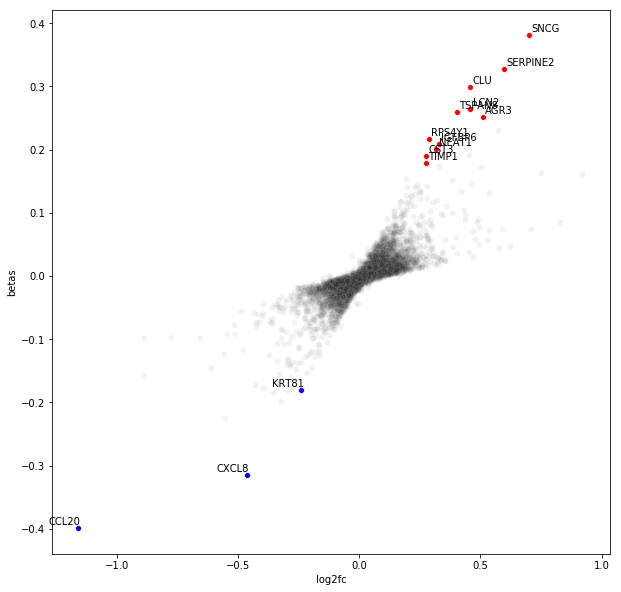

In [8]:
from adjustText import adjust_text
linreg_res_fp = "/data/yosef2/users/mattjones/projects/metastasis/30k/poisson_reg_de.txt"

# linreg_res = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/poisson_reg_de.ALL_fixed.txt", sep='\t', index_col = 0)
linreg_res = pd.read_csv(linreg_res_fp, sep='\t', index_col = 0)

# drop values where the likelihood of model was 0
linreg_res = linreg_res.dropna(subset=['pvalues'], axis=0)

linreg_res["fdr"] = multi.multipletests(linreg_res["pvalues"], alpha=0.05, method='fdr_bh')[1]
linreg_res['log10qval'] = -np.log10(linreg_res['fdr'])
linreg_res['log10qval'] = linreg_res.apply(lambda x: min(350, x.log10qval), axis=1)

discScore = lambda z,p: p * np.abs(z)

pseudoStd = np.std(linreg_res['log2fc'])
linreg_res.loc[:, 'disc'] = discScore(linreg_res['log2fc']/pseudoStd, linreg_res['log10qval'])
linreg_res.loc[:,'thresh'] = discScore(linreg_res['log2fc']/pseudoStd, linreg_res['log10qval']) >= 600

fig, axis = plt.subplots(1,1, figsize=(10, 10))
sns.scatterplot(x='log2fc', y = 'betas', data=linreg_res.loc[((linreg_res['thresh'] == True) & (linreg_res['betas'] >=0))], color='red')
sns.scatterplot(x='log2fc', y = 'betas', data=linreg_res.loc[((linreg_res['thresh'] == True) & (linreg_res['betas'] < 0))], color='blue')
sns.scatterplot(x='log2fc', y = 'betas', data=linreg_res.loc[linreg_res['thresh'] == False], color='black', alpha=0.05)
for gene, row in linreg_res.loc[linreg_res['thresh']].iterrows():
    
    axis.text(row['log2fc']+0.01, row['betas']+0.01, gene, fontsize=10,
    horizontalalignment = 'left' if row['log2fc'] > 0 else 'right', verticalalignment='center')
    
plt.show()


linreg_res.to_csv(linreg_res_fp, sep='\t')
# linreg_res.to_csv('/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/poisson_reg_de.ALL.txt', sep='\t')

In [431]:
subdf = pd.DataFrame.from_dict({'scTreeMetRate': adata.obs['scTreeMetRate'] - adata.obs['scTreeMetRate'].mean()}, orient='columns')
target_genes = ['IFI27', 'REG4', 'LGALS1', 'IFI6', 'TNNT1', 'PRKCDBP', 'DPYSL3', 'TFF1', 
                'KRT17', 'RPS4Y1', 'FXYD2', 'CFD', 'CXCL8', 'ID3', 'ASS1', 'SLPI', "MALAT1", "VIM", "GAPDH", "NFKBIA"]
for gene in target_genes:
    ex = np.log2(1+adata.X[:,(adata.var_names == gene)].toarray()[:,0])
    subdf[gene] = ex

subdf['MetClass'] = subdf.apply(lambda x: 'High' if x.scTreeMetRate >= 0 else 'Low', axis=1)
subdf.head(5)

,scTreeMetRate,IFI27,REG4,LGALS1,IFI6,TNNT1,PRKCDBP,DPYSL3,TFF1,KRT17,...,CFD,CXCL8,ID3,ASS1,SLPI,MALAT1,VIM,GAPDH,NFKBIA,MetClass
0,,,,,,,,,,,,,,,,,,,,,
LL.AAACCTGGTACATGTC-1,-0.080727,0.000000,0.000000,3.760921,0.000000,0.000000,0.000000,0.000000,1.628896,0.000000,...,2.049333,2.374490,0.0,1.033075,0.000000,7.284148,4.309967,4.921183,2.049333,Low
LL.AAACCTGTCAAGGTAA-1,0.124891,1.204846,1.641930,2.880194,0.407387,0.000000,0.724705,0.984658,3.634576,0.000000,...,0.218026,0.000000,0.0,0.000000,0.000000,5.896454,2.847866,4.362953,0.218026,High
LL.AAACGGGGTCTTGATG-1,0.161660,0.000000,0.781972,2.969944,1.659212,0.443331,1.484756,0.781972,3.764569,0.000000,...,0.781972,0.000000,0.0,0.000000,0.443331,6.237758,2.309508,4.947592,0.443331,High
LL.AAACGGGGTGTTAAGA-1,-0.080727,0.000000,0.000000,1.977274,0.000000,0.000000,0.000000,0.000000,0.000000,0.666753,...,1.744155,0.000000,0.0,0.000000,1.977274,6.569847,4.924804,5.334935,0.000000,Low
LL.AAACGGGTCGTTTAGG-1,-0.066113,1.175878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.593883,0.000000,...,3.096906,4.710727,0.0,0.000000,1.175878,5.880880,3.624537,4.118604,1.815004,Low


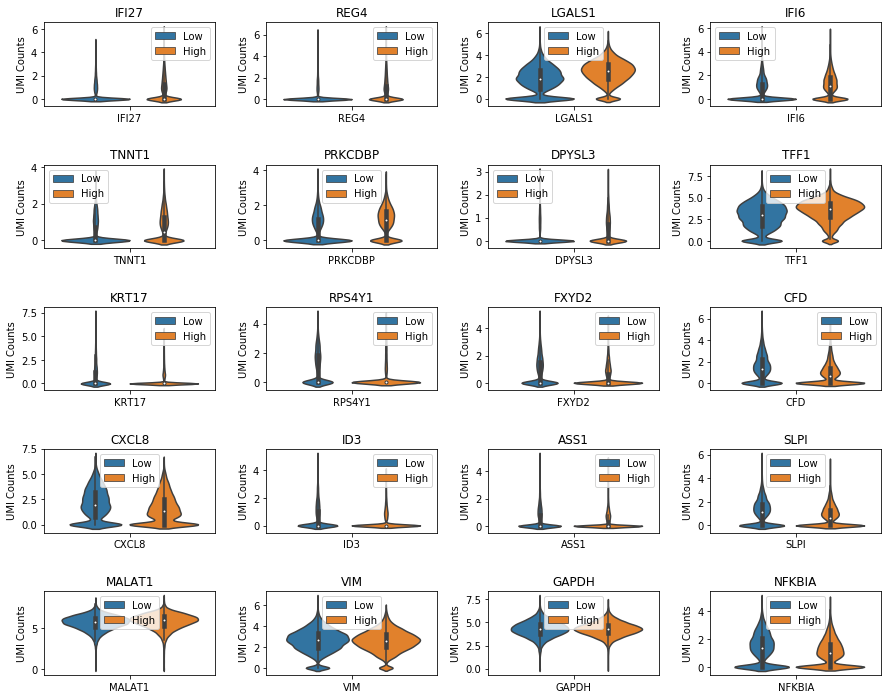

In [448]:
melted_df = pd.DataFrame()
melted_df = pd.melt(subdf, id_vars=['MetClass'], value_vars=target_genes, var_name='gene', value_name='expr')

fig, axarr = plt.subplots(nrows=5, ncols=4, figsize=(15, 12))
# h = plt.figure(figsize = (15, 7))
for j, gene in zip(range(20), target_genes):
    x = int((j)/4)
    y = int((j)%4)
    sns.boxplot(x = 'gene', y = 'expr', data = melted_df[melted_df['gene'] == gene], hue = 'MetClass', 
                whis=[9,91], showfliers=False, ax = axarr[x, y])
    axarr[x,y].legend(loc=False)
    axarr[x,y].set_title(gene)
    axarr[x,y].set_xlabel('')
    axarr[x, y].set_ylabel('UMI Counts')    
plt.subplots_adjust(hspace=0.7, wspace=0.3)
# plt.savefig("poisson_de_hits_boxplot.eps")

plt.show()
    

   class     gene      mean
0   High     REG4  0.693865
1   High     IFI6  1.121110
2   High    IFI27  0.721058
3   High  PRKCDBP  1.076093
4   High    TNNT1  0.689227
5   High    KRT17  0.252588
6   High   RPS4Y1  0.280519
7   High    FXYD2  0.391180
8   High      ID3  0.268041
9   High     ASS1  0.248239
10   Low     REG4  0.273125
11   Low     IFI6  0.692250
12   Low    IFI27  0.337058
13   Low  PRKCDBP  0.622335
14   Low    TNNT1  0.400014
15   Low    KRT17  0.677131
16   Low   RPS4Y1  0.936515
17   Low    FXYD2  0.799493
18   Low      ID3  0.534429
19   Low     ASS1  0.432504


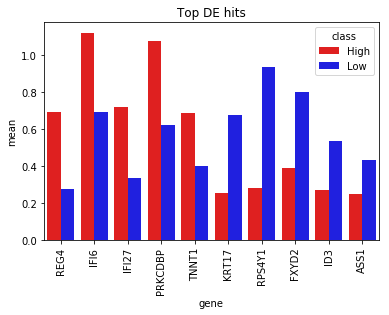

In [143]:
meandf = subdf.groupby('MetClass').agg(dict(zip(target_genes, ['mean']*10)))
_meandf = pd.DataFrame.from_dict({"class": ['High']*10 + ["Low"] * 10}, orient='columns')

for j in range(20):
    group = ['High', 'Low'][j // 10]
    gene = target_genes[int(j % 10)]
    _meandf.loc[j, 'gene'] = gene
    _meandf.loc[j, 'mean'] = meandf.loc[group, gene]

print(_meandf)
sns.barplot(x = 'gene', y = 'mean', data = _meandf, hue = "class", palette = {'red', 'blue'})
plt.xticks(rotation = 90)
plt.title("Top DE hits")
plt.savefig("poisson_de_hits_barplot.eps")

### Evaluate reproducibility of other mice

In [3]:
hits5k = pd.read_csv('/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/poisson_reg_de.ALL_fixed.txt', sep='\t', index_col = 0)
hits = hits5k[hits5k['thresh'] == True]
signif5k = hits5k[hits5k['fdr'] < 0.01]
discScore = lambda z,p: p * np.abs(z)

print(signif5k.shape)

(1577, 7)


In [16]:
from collections import defaultdict 

hits10k = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/10k/RNA/poisson_reg_de.txt", sep='\t', index_col = 0)
hits100k = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/RNA/poisson_reg_de.txt", sep='\t', index_col = 0)
hits30k = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/30k/poisson_reg_de.txt", sep='\t', index_col = 0)

hits10k = hits10k.dropna(subset=['pvalues'], axis=0)
hits100k = hits100k.dropna(subset=['pvalues'], axis=0)
hits30k = hits30k.dropna(subset=['pvalues'], axis=0)

hits10k["fdr"] = multi.multipletests(hits10k["pvalues"], alpha=0.05, method='fdr_bh')[1]
hits100k["fdr"] = multi.multipletests(hits100k["pvalues"], alpha=0.05, method='fdr_bh')[1]
hits30k["fdr"] = multi.multipletests(hits30k["pvalues"], alpha=0.05, method='fdr_bh')[1]

reproduced = defaultdict(list)
up = defaultdict(list)
dwn = defaultdict(list)


# form lists of up/dwn lists for 5k, 10k, 100k, 30k
for n, mouse in zip(['5k', '10k', '100k', '30k'], [hits5k, hits10k, hits100k, hits30k]):
    
    up_hits = mouse[(mouse['log2fc'] > 0) & (mouse['fdr'] < 0.01)]
    dwn_hits = mouse[(mouse['log2fc'] < 0) & (mouse['fdr'] < 0.01)]
    
    #print(f'{up_hits.shape[0]} up genes for {n}')
    #print(f'{dwn_hits.shape[0]} down genes for {n}')
    print(f'{up_hits.shape[0] + dwn_hits.shape[0]} total genes for {n}')
    
    up_hits.to_csv(f"data/{n}.up_genes.txt", sep='\t')
    dwn_hits.to_csv(f"data/{n}.down_genes.txt", sep='\t')

for n, mouse in zip(['10k', '100k', '30k'], [hits10k, hits100k, hits30k]):
    
    num_signif_reproduced = 0
    for hit in signif5k.index:
        
        if hit not in mouse.index:
            continue
        
        hit_cmp = mouse.loc[hit]
        
        if hit_cmp['fdr'] > 0.01:
            continue
        
        if hit_cmp['log2fc'] * signif5k.loc[hit,'log2fc'] >= 0:
            num_signif_reproduced += 1
            
    print('Mouse ' + n + " - Number reproduced significant genes: " + str(num_signif_reproduced) + " of " + str(mouse[mouse['fdr'] < 0.01].shape[0]))
            

for n, mouse in zip(['10k', '100k', '30k'], [hits10k, hits100k, hits30k]):
    for hit in hits.index:

        if hit not in mouse.index:
            continue
            
        hit_cmp = mouse.loc[hit]
        
        if hit_cmp['fdr'] > 0.01:
            continue
        
        if hit_cmp['log2fc'] * hits.loc[hit,'log2fc'] >= 0:
            if hit_cmp['log2fc'] > 0:
                up[n].append(hit)
            else:
                dwn[n].append(hit)
                
            reproduced[n].append(hit)
            
for n in reproduced.keys():
    print('Mouse ' + str(n))
    print('up reproduced: ' + str(up[n]))
    print('down reproduced: ' + str(dwn[n]))
    print()
    
print(np.intersect1d(reproduced['10k'], np.intersect1d(reproduced['100k'], reproduced['30k'])))


1577 total genes for 5k
1965 total genes for 10k
1136 total genes for 100k
877 total genes for 30k
Mouse 10k - Number reproduced significant genes: 407 of 1965
Mouse 100k - Number reproduced significant genes: 431 of 1136
Mouse 30k - Number reproduced significant genes: 539 of 877
Mouse 10k
up reproduced: ['SH3BGRL3', 'IFI6', 'CLU', 'IFI27', 'B2M', 'TNNT1', 'LGALS1', 'MT-CO2', 'MT-CYB']
down reproduced: ['EFNA1', 'CCL20', 'CXCL1', 'CXCL2', 'FXYD2', 'KRT7', 'NFKBIA', 'KRT17', 'FOSB', 'RPS4Y1']

Mouse 100k
up reproduced: ['SH3BGRL3', 'FN1', 'DPYSL3', 'CLU', 'PRSS3', 'IFI27', 'B2M', 'SEPW1', 'TNNT1', 'LGALS1', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB']
down reproduced: ['ID3', 'EFNA1', 'CXCL1', 'CXCL2', 'CASC15', 'ASS1', 'FXYD2', 'KRT7', 'SLPI', 'CFD', 'JUNB', 'FOSB']

Mouse 30k
up reproduced: ['SH3BGRL3', 'IFI6', 'TAGLN2', 'FN1', 'DPYSL3', 'CLU', 'MUC5AC', 'TSPAN8', 'IFI27', 'B2M', 'SEPW1', 'TNNT1', 'LGALS1', 'TFF1', 'MT-CO3', 'MT-CYB']
down reproduced: ['ID3', 'EFNA1', 'CCL20', 'CXCL8', 'C

In [483]:
hits10k.loc['ID3']

betas      0.0388904
pvalues    0.0488005
test         Poisson
log2fc      -0.10561
fdr         0.169125
Name: ID3, dtype: object

## Evaluate significant signature scores from Vision

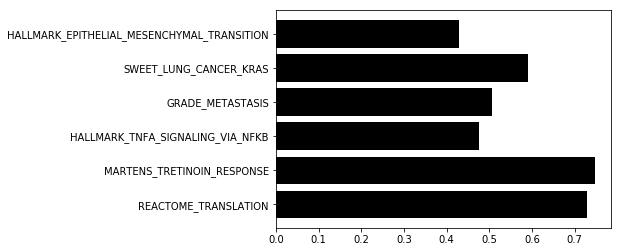

In [12]:
consist_scores = pd.read_csv("../JQ19/5k/RNA/JQ19.sigscores.consistencies.txt", sep='\t', index_col = 0)

sigs = ['REACTOME_TRANSLATION', 'MARTENS_TRETINOIN_RESPONSE', "HALLMARK_TNFA_SIGNALING_VIA_NFKB", "GRADE_METASTASIS",
        "SWEET_LUNG_CANCER_KRAS", "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"]
scores = [consist_scores.loc[s, 'Consistency'] for s in sigs]

plt.barh(sigs, scores, color='black')
# plt.yticks(rotation=45)

plt.show()

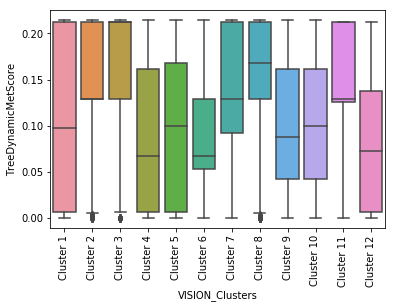

In [117]:
vis_meta = pd.read_csv("../JQ19/5k/RNA/ALL_Samples/JQ19.ALL.metadata.txt", sep='\t', index_col = 0)

sns.boxplot(x = 'VISION_Clusters', y='TrDynamicMetScore', data=vis_meta)
plt.xticks(rotation=90)
plt.show()

## Look at bulk correlates

In [449]:
for sig in tqdm(sig_scores_subset.columns):
    met_scores[sig] = 0
    for lg, g in adata.obs.groupby("LineageGroup"):
        if int(lg) not in met_scores.index:
            continue
        cells = g.index.values
        met_scores.loc[lg, sig] = np.mean(sig_scores_subset.loc[cells, sig])


  0%|          | 0/3685 [00:00<?, ?it/s]/home/eecs/mattjones/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]

100%|██████████| 3685/3685 [10:10<00:00,  6.04it/s]


In [ ]:
met_scores.to_csv("data/5k/5k.met_and_sig_scores.txt", sep='\t')

In [461]:
met_scores = met_scores[met_scores['Filtered'] == False]

In [462]:
corrs = []
ks_stats = []

signif_sigs = {}
for sig in tqdm(sig_scores_subset.columns):
    
    pcorr = scs.pearsonr(met_scores[sig], met_scores["TreeMetRate"])[0]  
    scorr, pval = scs.spearmanr(met_scores[sig], met_scores['TreeMetRate'])
    # slope, intercept, r_value, pval, std_err = scs.linregress(met_scores[sig], met_scores['Dynamic'])
    #ks = scs.ks_2samp(met_scores[sig], met_scores["Evolving"])[0]
    if abs(scorr) > 0.5:
        print(sig, pcorr, scorr)
        signif_sigs[sig] = scorr
    corrs.append((scorr, pval))


  0%|          | 0/3685 [00:00<?, ?it/s]

HALLMARK_INTERFERON_ALPHA_RESPONSE 0.5106113225653592 0.5002939663519668



 31%|███       | 1142/3685 [00:01<00:03, 777.75it/s]

REACTOME_INTERFERON_GAMMA_SIGNALING 0.5338021817419571 0.507705573290117



 46%|████▌     | 1696/3685 [00:02<00:02, 771.43it/s]

BOWIE_RESPONSE_TO_EXTRACELLULAR_MATRIX 0.5429941981569011 0.5470731738822748
BOWIE_RESPONSE_TO_TAMOXIFEN 0.5511966801193027 0.5519022662215796



 48%|████▊     | 1774/3685 [00:02<00:02, 752.88it/s]

XU_AKT1_TARGETS_48HR 0.5237304755121112 0.5229067161321023
EINAV_INTERFERON_SIGNATURE_IN_CANCER 0.5511291395313483 0.5390316853346502



 62%|██████▏   | 2296/3685 [00:03<00:01, 710.66it/s]

TAVOR_CEBPA_TARGETS -0.5175008862415867 -0.5265810255207036
BENNETT_SYSTEMIC_LUPUS_ERYTHEMATOSUS 0.5234584515847228 0.5456034501268344



 73%|███████▎  | 2679/3685 [00:03<00:01, 751.61it/s]

MARTINEZ_RB1_AND_TP53_TARGETS 0.4649611284624104 0.5018686703756531



 83%|████████▎ | 3067/3685 [00:04<00:00, 764.72it/s]

CHIANG_LIVER_CANCER_SUBCLASS_INTERFERON 0.5419798885366324 0.544448667176131



 95%|█████████▍| 3484/3685 [00:04<00:00, 819.64it/s]

ANASTASSIOU_MULTICANCER_INVASIVENESS_SIGNATURE 0.5330059589072065 0.5054799916033071
HECKER_IFNB1_TARGETS 0.5359270437414266 0.5761527081863489



100%|██████████| 3685/3685 [00:04<00:00, 759.99it/s]


In [464]:
sig_df = pd.DataFrame.from_dict(dict(zip(sig_scores_subset.columns, corrs)), orient='index', columns=['SCorr', 'Pval'])
sig_df['signature'] = sig_df.index

sig_df['sign'] = sig_df.apply(lambda x: 'neg' if x.SCorr < 0 else 'pos', axis=1)

sig_df["Qval"] = multi.multipletests(sig_df["Pval"], alpha=0.05, method='fdr_bh')[1]

sig_df[sig_df['SCorr'] > 0.3].sort_values(by = 'SCorr', ascending=False).head(10)

sig_df.to_csv('data/5k/5k.signature_metscore_corr.41220.txt', sep='\t')

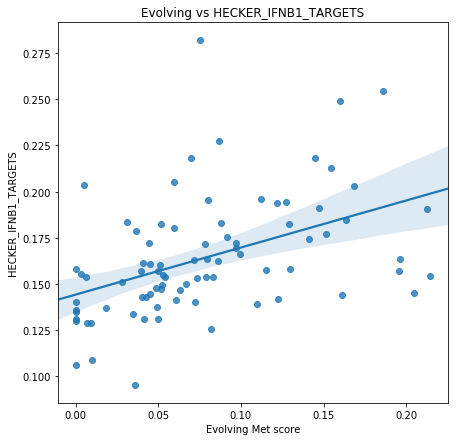

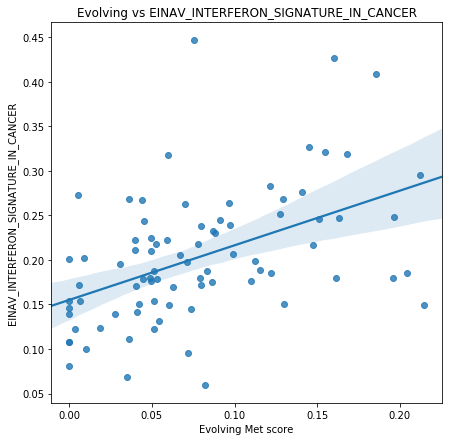

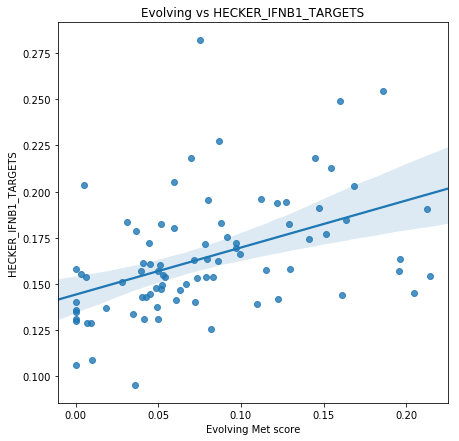

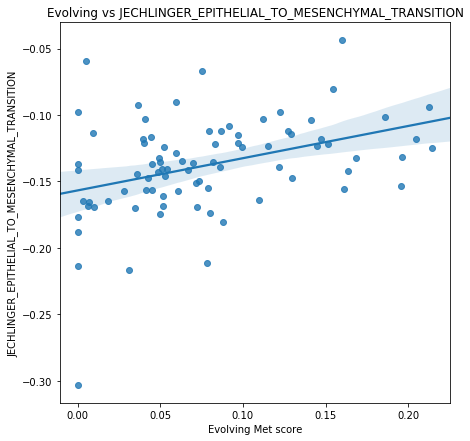

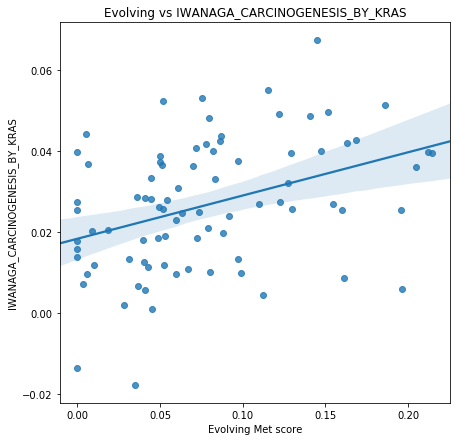

In [82]:
for sig in ["HECKER_IFNB1_TARGETS", "EINAV_INTERFERON_SIGNATURE_IN_CANCER", "HECKER_IFNB1_TARGETS", "JECHLINGER_EPITHELIAL_TO_MESENCHYMAL_TRANSITION", "IWANAGA_CARCINOGENESIS_BY_KRAS"]:
    h = plt.figure(figsize = (7,7))
    sns.regplot(met_scores["Dynamic"],met_scores[sig], ".")
    plt.title("Evolving vs " + sig)
    plt.ylabel(sig)
    plt.xlabel("Evolving Met score")
    # plt.savefig('figs/100k/' + sig + "_evomet_corr.100k.pdf")

## Run genewise analysis with pseudobulk 

In [50]:
met_scores = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/MetastasisTracing/data/lg_metastatic_scoresAllele.5k.txt", sep='\t', index_col = 0)
met_scores.head(5)

,TissueDispersion,TreeMetScore,AlleleMetScore,TreeMetScore_NJ
57,0.133281,0.005263,0.086924,0.005376
20,0.425938,0.059351,0.152211,0.038869
18,0.796865,0.617371,0.619713,0.397938
12,0.716489,0.042420,0.125733,0.053461
6,0.668951,0.053079,0.288021,0.073146


In [52]:
lg_groups = {}
for n, g in adata.obs.groupby("LineageGroup"):
    lg_groups[int(n)] = g.index
    
agg_counts = np.zeros((adata.X.shape[1], len(adata.obs['LineageGroup'].unique())))
for i, j in tqdm(zip(range(len(lg_groups.keys())), lg_groups.keys()), desc="pooling cells"):

    lg = lg_groups[j]
    filt = list(map(lambda x: x in lg, adata.obs_names))
    if adata[filt,:].shape[0] == 0: 
        lg_counts = np.zeros((adata.X.shape[1],))
    else:
        lg_counts = np.mean(adata[filt,:].X, axis=0)
    
    agg_counts[:,i] = lg_counts

lg_adata = sc.AnnData(agg_counts.T)
lg_adata.obs_names = list(lg_groups.keys())
lg_adata.var_names = adata.var_names
lg_adata.obs["dynamic"] = met_scores.loc[lg_adata.obs_names, "TreeMetScore"]
lg_adata.obs["static"] = met_scores.loc[lg_adata.obs_names, "TissueDispersion"]

meta_filter = np.logical_not(lg_adata.obs["dynamic"].isna())
lg_adata = lg_adata[meta_filter,:]
lg_adata.obs.shape


pooling cells: 0it [00:00, ?it/s]
pooling cells: 1it [00:00,  1.12it/s]
pooling cells: 2it [00:01,  1.26it/s]
pooling cells: 3it [00:01,  1.59it/s]
pooling cells: 5it [00:01,  2.16it/s]
pooling cells: 7it [00:01,  2.92it/s]
pooling cells: 9it [00:02,  3.91it/s]
pooling cells: 11it [00:02,  5.14it/s]
pooling cells: 13it [00:02,  6.60it/s]
pooling cells: 16it [00:02,  8.37it/s]
pooling cells: 19it [00:02, 10.40it/s]
pooling cells: 22it [00:02, 12.69it/s]
pooling cells: 25it [00:02, 15.13it/s]
pooling cells: 28it [00:02, 17.69it/s]
pooling cells: 31it [00:02, 19.87it/s]
pooling cells: 34it [00:03, 22.07it/s]
pooling cells: 37it [00:03, 23.96it/s]
pooling cells: 41it [00:03, 25.90it/s]
pooling cells: 45it [00:03, 27.38it/s]
pooling cells: 49it [00:03, 28.37it/s]
pooling cells: 53it [00:03, 29.26it/s]
pooling cells: 57it [00:03, 30.03it/s]
pooling cells: 61it [00:03, 30.22it/s]
pooling cells: 65it [00:04, 30.78it/s]
pooling cells: 69it [00:04, 30.77it/s]
pooling cells: 73it [00:04, 31.05it

(83, 2)

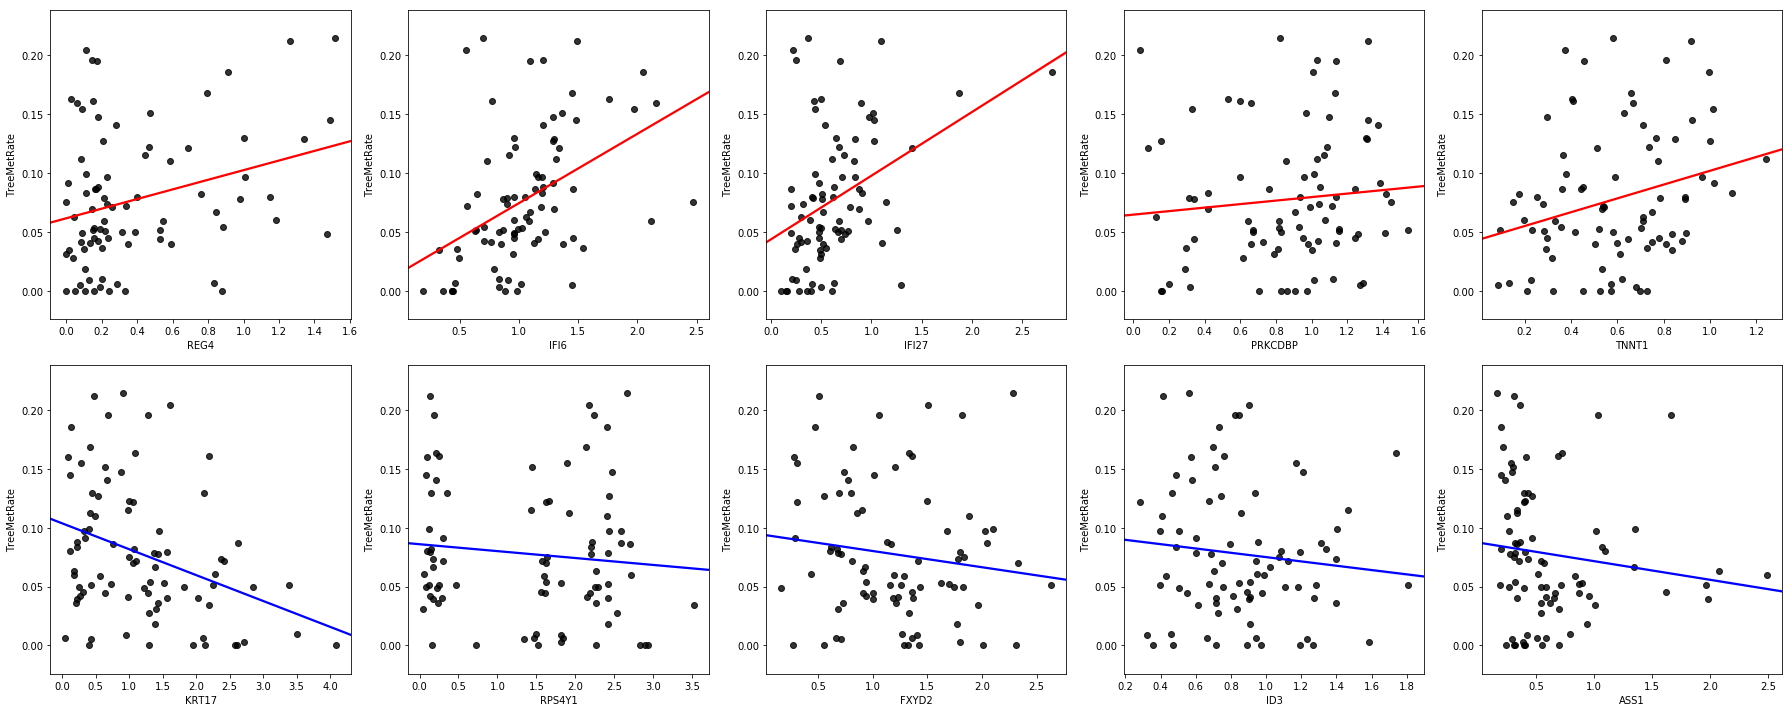

In [69]:
target_genes = ['REG4', 'IFI6', 'IFI27', 'PRKCDBP', 'TNNT1',  'KRT17', 'RPS4Y1', 'FXYD2', 'ID3', 'ASS1']

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
for k, gene in zip(range(10), target_genes):
    
    i = int(k / 5)
    j = int(k % 5)
    
    color = ['Red', 'Blue'][i]
    
    ex = np.log2(1+lg_adata.X[:,(lg_adata.var_names == gene)][:,0])
    met_score = lg_adata.obs['dynamic']
    
    sns.regplot(ex, met_score, color='black', ax=axes[i, j], ci=1, line_kws={'color': color})
    # axes[i, j].scatter(ex, met_score, color='black')
    axes[i,j].set_xlabel(gene)
    axes[i, j].set_ylabel('TreeMetRate')
plt.tight_layout()

plt.savefig('poisson_de_hits_pseudobulk.eps')
plt.show()

In [375]:
hallmark_sigs = gseapy.parser.gsea_gmt_parser("/data/yosef2/users/mattjones/data/h.all.v5.2.symbols.gmt")
c2_sigs = gseapy.parser.gsea_gmt_parser("/data/yosef2/users/mattjones/data/c2.all.v6.0.symbols.gmt")
c6_sigs = gseapy.parser.gsea_gmt_parser("/data/yosef2/users/mattjones/data/c6.all.v6.0.symbols.gmt")

all_sigs = {**hallmark_sigs, **c2_sigs, **c6_sigs}

In [376]:
gene_counter = {}
for sig in tqdm(signif_sigs, desc="trying significant signatures"):
    
    if sig not in all_sigs:
        up_sig, dn_sig = sig + "_UP", sig + "_DN"
        if up_sig in all_sigs:
            res, up_genes = de_utils.run_lin_reg(lg_adata, all_sigs[up_sig], 'dynamic')
        if dn_sig in all_sigs:
            res, down_genes = de_utils.run_lin_reg(lg_adata, all_sigs[dn_sig], 'dynamic')
        
        genes = up_genes + down_genes
    else:
        res, genes = de_utils.run_lin_reg(lg_adata, all_sigs[sig], 'dynamic')

    for g in genes:
        if g not in gene_counter:
            gene_counter[g] = 0
        gene_counter[g] += 1
        
df = pd.DataFrame.from_dict(gene_counter, orient="index")

trying significant signatures:   0%|          | 0/37 [00:00<?, ?it/s]/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
trying significant signatures: 100%|██████████| 37/37 [00:00<00:00, 49.61it/s]


<Figure size 864x864 with 0 Axes>

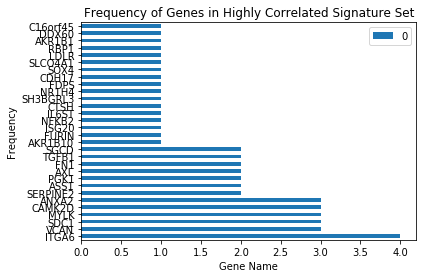

<Figure size 432x288 with 0 Axes>

In [381]:
h = plt.figure(figsize=(12,12))
df.sort_values(by=0, ascending=False).head(30).plot(kind='barh')
plt.title("Frequency of Genes in Highly Correlated Signature Set")
plt.xlabel("Gene Name")
plt.ylabel("Frequency")
plt.show()
plt.savefig("figs/100k/gene_freq_corrsigs.100k.pdf", bbox_inches='tight')

In [382]:
def run_lin_reg_ALL_GENES(adata, meta_var):

    pvals = {}
    betas = {}
    corrs = {}
    scorrs = {}

    meta_scores = adata.obs[meta_var]

    for gene in tqdm(adata.var_names):
        ex = adata.X[:,(adata.var_names == gene)][:,0]
        slope, intercept, r_value, p_value, std_err = scs.linregress(meta_scores, ex)

        pvals[gene] = p_value
        betas[gene] = slope
        corrs[gene] = r_value

        scorrs[gene] = scs.spearmanr(meta_scores, ex)[0]

    return pvals, betas, corrs, scorrs

In [383]:
all_pvalues, all_betas, all_corr, all_scorr = run_lin_reg_ALL_GENES(lg_adata, 'dynamic')

genedf = pd.DataFrame.from_dict(all_pvalues, orient="index", columns=['pvalues'])
genedf["betas"] = list(map(lambda x: all_betas[x], all_pvalues.keys()))
genedf["Corr"] = list(map(lambda x: all_corr[x], all_pvalues.keys()))
genedf["SpearmanCorr"] = list(map(lambda x: all_scorr[x], all_pvalues.keys()))
genedf["Adjusted P-values"] = multi.multipletests(genedf["pvalues"], alpha=0.05, method='fdr_bh')[1]

genedf.sort_values(by="Adjusted P-values", ascending=True).head()


  0%|          | 0/4275 [00:00<?, ?it/s]/home/eecs/mattjones/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/eecs/mattjones/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
100%|██████████| 4275/4275 [00:07<00:00, 601.55it/s]
